In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [3]:
from os.path import exists, join, splitext

In [4]:
config_filename = 'uncer.yaml'
config1 = read_config(config_filename)
config2 = read_config('default.yaml')

In [5]:
percentile_dict1 = {}
percentile_dict2 = {}

  0%|          | 0/15000 [00:00<?, ?it/s]Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_17112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 172                 | 173                 | 174                 | 175                 | 176                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 | 2020-10-17 00:00:00 | 2020-10-18 00:00:00 | 2020-10-19 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 236513.43           | 238242.43           | 240335.0      

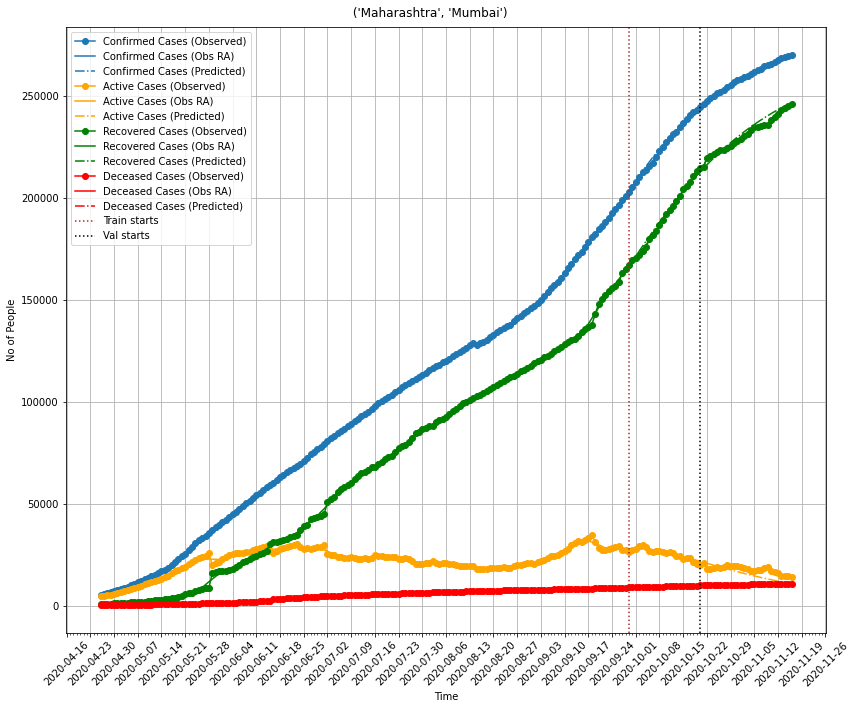

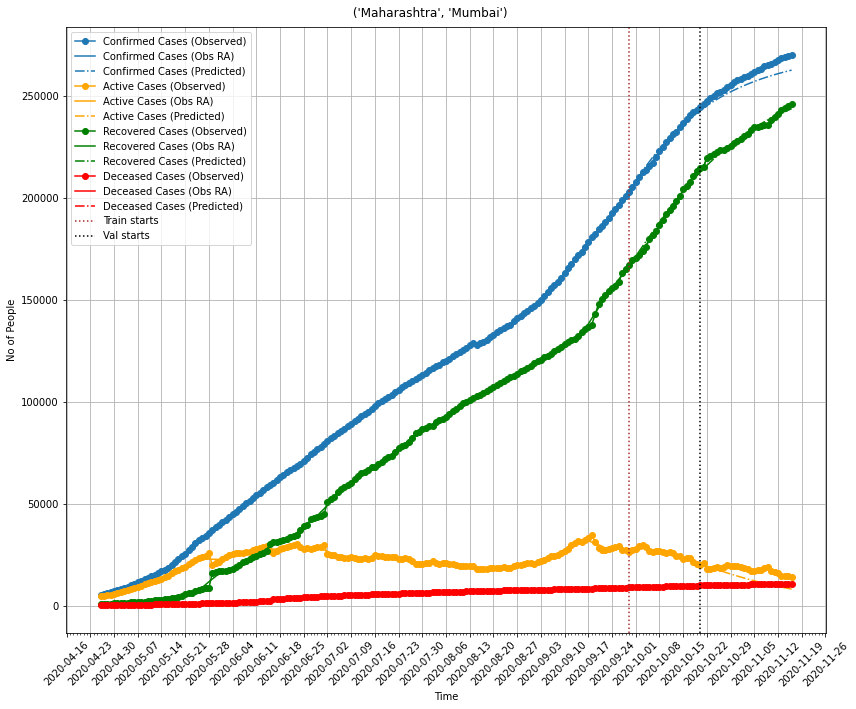

In [6]:
percentile_dict1['m1'] = single_fitting_cycle(**copy.deepcopy(config1['fitting']))
percentile_dict2['m1'] = single_fitting_cycle(**copy.deepcopy(config2['fitting']))

In [20]:
for i in percentile_dict1['m1'].keys():
    print(i)

plots
best_params
default_params
variable_param_ranges
optimiser
df_prediction
df_district
df_train
df_val
df_loss
trials
data_last_date
smoothing_description
df_district_unsmoothed
run_params
forecasts
trials_processed


In [26]:
percentile_dict1['m1']['df_loss']
from main.seir.forecast import _get_top_k_trials as topk
_,loss = topk(percentile_dict1['m1'], k = 10)
loss

array([0.65805377, 0.70211543, 0.72530423, 0.73387708, 0.73387708,
       0.73387708, 0.73387708, 0.7481853 , 0.75787977, 0.75787977])

In [27]:
percentile_dict1['m1']['df_loss']
from main.seir.forecast import _get_top_k_trials as topk
_,loss = topk(percentile_dict2['m1'], k = 10)
loss

array([0.50957892, 0.52630977, 0.54360068, 0.54864803, 0.56247221,
       0.56635161, 0.57007685, 0.57786462, 0.58082107, 0.59756953])

In [24]:
percentile_dict2['m1']['df_loss']

,train,val
total,0.449864,0.959642
active,2.32936,4.4934
recovered,0.645506,1.02246
deceased,0.126253,0.0683574


In [7]:
percentile_dict1['m1']['forecasts'] = {}
percentile_dict1['m1']['forecasts']['best'] = get_forecast(percentile_dict1, train_fit='m1', 
                                                           model=config1['fitting']['model'], 
                                                           days=config1['forecast']['forecast_days'])

percentile_dict1['m1']['trials_processed'] = forecast_all_trials(percentile_dict1, train_fit='m1', 
                                                                 model=config1['fitting']['model'], 
                                                                 forecast_days=config1['forecast']['forecast_days'])

8it [00:00, 72.91it/s]getting forecasts ..
getting forecasts ..
3000it [00:21, 139.00it/s]


In [8]:
percentile_dict2['m1']['forecasts'] = {}
percentile_dict2['m1']['forecasts']['best'] = get_forecast(percentile_dict2, train_fit='m1', 
                                                           model=config2['fitting']['model'], 
                                                           days=config2['forecast']['forecast_days'])

percentile_dict2['m1']['trials_processed'] = forecast_all_trials(percentile_dict2, train_fit='m1', 
                                                                 model=config2['fitting']['model'], 
                                                                 forecast_days=config2['forecast']['forecast_days'])

14it [00:00, 138.79it/s]getting forecasts ..
getting forecasts ..
3000it [00:22, 136.17it/s]


In [9]:
uncertainty_args1 = {'predictions_dict': percentile_dict1, **config1['uncertainty']['uncertainty_params']}
uncertainty1 = config1['uncertainty']['method'](**uncertainty_args1)

In [10]:
uncertainty_args2 = {'predictions_dict': percentile_dict2, **config2['uncertainty']['uncertainty_params']}
uncertainty2 = config2['uncertainty']['method'](**uncertainty_args2)

100%|██████████| 100/100 [01:43<00:00,  1.03s/trial, best loss: 1.7396742409206174]


In [ ]:
print("MCMC-",uncertainty1.p_val)
print("BO-",uncertainty2.p_val)

In [11]:
uncertainty_forecasts1 = uncertainty1.get_forecasts()
uncertainty_forecasts2 = uncertainty2.get_forecasts()

In [15]:
mcmc = []
bo = []
key = []
for i in uncertainty_forecasts1.keys():
    key.append(i)
    mcmc.append(uncertainty_forecasts1[i]['df_loss'].mean())
    bo.append(uncertainty_forecasts2[i]['df_loss'].mean())

In [16]:
data = {"mcmc":mcmc,"bo":bo}
import pandas as pd
import seaborn as sns

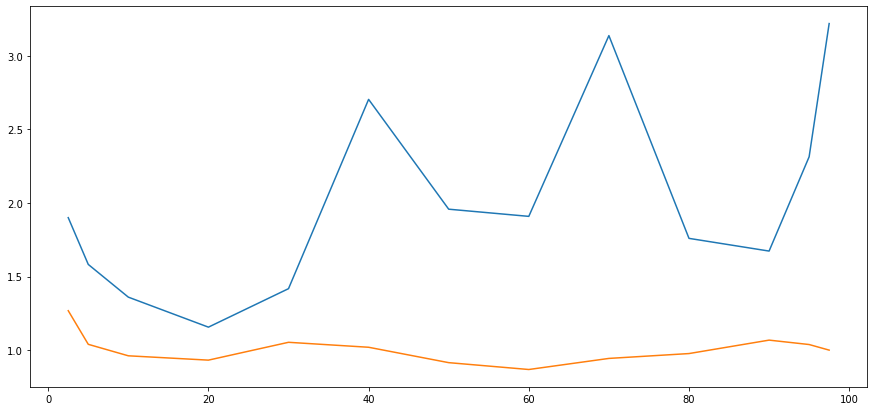

In [17]:
plt.figure(figsize= (15,7))
plt.plot(key,mcmc)
plt.plot(key,bo)
